In [1]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

/home/ishan/Desktop/Python/llms-app/food-labels-gemini/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# llm = ChatGoogleGenerativeAI(model="gemini-pro")
# result = llm.invoke("Write a ballad about LangChain")
# print(result.content)

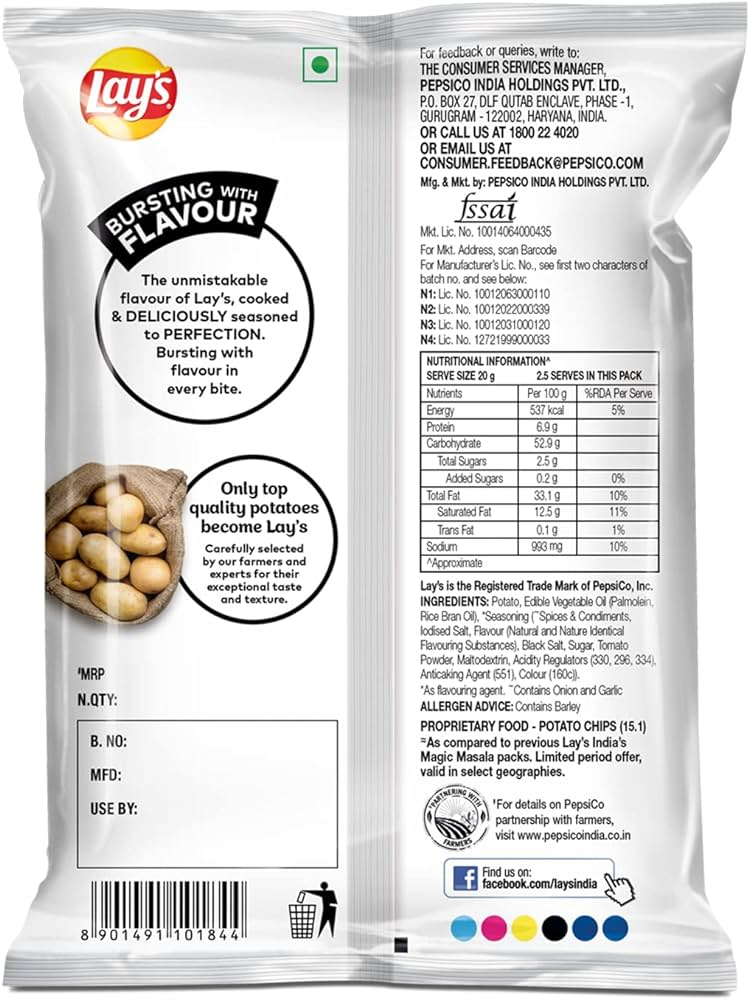

In [3]:
from PIL import Image

# Open the image file
file = open("images/lays.jpg", "rb")
image = Image.open(file)

# Display the image
image

In [6]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-pro-vision", temperature=0)

#TODO: Write better prompts to extract the list of ingredients and the nutritional information from the image. 
# The prompt should include all the information that we need to extract from the image. For example, the prompt should include the details about serve size and the serves in this pack details as well.
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "Extract the list of ingredients and the nutritional information from the image provided to you. Include the details about serve size and the serves in this pack details as well. Give the details in a json format.",
        },
        {
            "type": "image_url", 
            "image_url": image
        },
    ]
)

response = llm.invoke([message])

In [7]:
print(str(response.content))

 | |  |
| ----------- | ----------- |
| **Ingredients** | Potatoes, Edible Vegetable Oil (Palmolenin, Rice Bran Oil), Seasoning [Spices & Condiments, lodized Salt, Sugar, Natural and Nature identical flavoring Substances], Black Salt, Sugar, Tomato Powder, Maltodextrin, Acidity Regulators (330, 334), Antioxident (551), Color (160b). |
| **Nutritional Information** | 
| ----------- | ----------- |
| **Serve Size** | 25 grams |
| **Serves in this Pack** | 5 |
| **Energy** | 537 kJ |
| **Protein** | 6.9 g |
| **Total Fat** | 29.9 g |
| **Saturated Fat** | 33.1 g |
| **Trans Fat** | 0.2 g |
| **Total Sugars** | 52.9 g |
| **Added Sugars** | 0 g |
| **Sodium** | 993 mg |
| **Dietary Fiber** | 12.5 g |
